# Use pure Pytorch tensor with high level primitives to build a neural network

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generate sample data

In [ ]:
def get_true_labels(X, weights_true, bias_true):
  return (-3 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

In [ ]:
n_samples = 150
input_dim = 3
output_dim = 2

torch.manual_seed(1)
max = 1
min = -1
X = (max - min) * torch.rand((n_samples, input_dim)) + min
print('Sample X: ' + str(X[:2]))

weights_true = torch.tensor([[5., 1., -10.], [-3., -5., -2.]])
bias_true = torch.tensor([[1.], [1.]])

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample y: ' + str(y_true[:2]))

Sample X: tensor([[ 0.5153, -0.4414, -0.1939],
        [ 0.4694, -0.9414,  0.5997]])
Sample y: tensor([[ 1.6341,  7.5860],
        [ 1.2345, 20.5349]])


# Plot data

In [ ]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

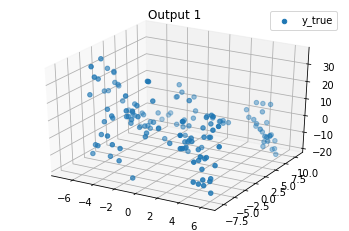

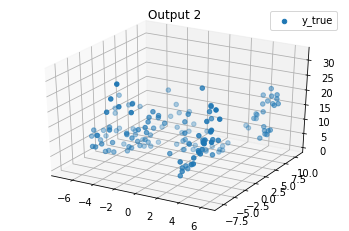

In [ ]:
plot_3d('Output 1', X, y_true[:,0])
plot_3d('Output 2', X, y_true[:,1])

# Build neural network
 

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    super(NeuralNet, self).__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers_nodes = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    layers = []
    for i in range(len(layers_nodes[:-1])):
      # Don't add activation function to last layer because this is a regression problem
      if i == len(layers_nodes[:-1]) - 1:
        layers.append(nn.Linear(layers_nodes[i], layers_nodes[i + 1]))
      else:
        layers.append(nn.Linear(layers_nodes[i], layers_nodes[i + 1]))
        if activation == 'relu':
          layers.append(nn.ReLU())

    self.layers = nn.ModuleList(layers)

  def forward(self, x):
    curr_out = X
    for layer in self.layers:
      curr_out = layer(curr_out)
    return curr_out
  
  def fit(self, X, y_true, lr, epochs):
    loss_fn  = nn.MSELoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    for epoch in range(epochs):
      optimizer.zero_grad()
      # Forward
      y_pred = self.forward(X)
      error = loss_fn(y_pred, y_true)
      print(error)
      error.backward()
      optimizer.step()

# Define hyperparameters

In [ ]:
epochs = 500
lr = 0.03

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

# Train neural network **with** ReLU activation

In [ ]:
model = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
print('Neural Network Architecture:')
print(model.layers)
print()

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

model.fit(X, y_true, lr, epochs)

y_pred = model.forward(X).detach().numpy()
err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Network Architecture:
ModuleList(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
)

Layer: layers.0.weight | Size: torch.Size([4, 3]) | Values : tensor([[ 0.1934,  0.3160,  0.5723],
        [-0.0603,  0.5554,  0.3709]], grad_fn=<SliceBackward>) 

Layer: layers.0.bias | Size: torch.Size([4]) | Values : tensor([0.4212, 0.1730], grad_fn=<SliceBackward>) 

Layer: layers.2.weight | Size: torch.Size([3, 4]) | Values : tensor([[-0.3560, -0.1093,  0.0049, -0.2889],
        [-0.1278, -0.2156,  0.4765,  0.4248]], grad_fn=<SliceBackward>) 

Layer: layers.2.bias | Size: torch.Size([3]) | Values : tensor([ 0.1843, -0.3667], grad_fn=<SliceBackward>) 

Layer: layers.4.weight | Size: torch.Size([2, 3]) | Values : tensor([[-0.3133,  0.0918,  0.1912],
        [ 0.4982, -0.3029, -0.4542]], grad_fn=<SliceBackward>) 

Layer: layers.4.bias | Size: torch.

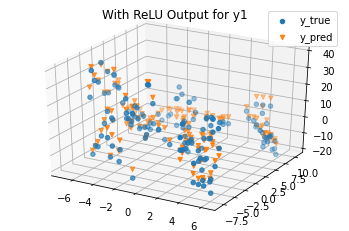

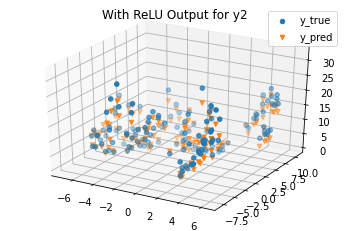

In [ ]:
plot_3d('With ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('With ReLU Output for y2', X, y_true[:,1], y_pred[:,1])

# Train neural network **without** ReLU activation
We can see the error is much larger than the model trained with a nonlinear activation function and the resulting prediction plot does not look as close to the true values compared to the plot with ReLU.

In [ ]:
model = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
print('Neural Network Architecture:')
print(model)
print()

model.fit(X, y_true, lr, epochs)

y_pred = model.forward(X).detach().numpy()
err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Network Architecture:
NeuralNet(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=3, bias=True)
    (2): Linear(in_features=3, out_features=2, bias=True)
  )
)

tensor(138.8785, grad_fn=<MseLossBackward>)
tensor(132.7242, grad_fn=<MseLossBackward>)
tensor(126.1769, grad_fn=<MseLossBackward>)
tensor(117.7503, grad_fn=<MseLossBackward>)
tensor(106.1025, grad_fn=<MseLossBackward>)
tensor(91.1165, grad_fn=<MseLossBackward>)
tensor(78.8959, grad_fn=<MseLossBackward>)
tensor(76.3756, grad_fn=<MseLossBackward>)
tensor(75.3676, grad_fn=<MseLossBackward>)
tensor(74.4861, grad_fn=<MseLossBackward>)
tensor(73.6399, grad_fn=<MseLossBackward>)
tensor(72.7598, grad_fn=<MseLossBackward>)
tensor(71.7797, grad_fn=<MseLossBackward>)
tensor(70.6294, grad_fn=<MseLossBackward>)
tensor(69.2373, grad_fn=<MseLossBackward>)
tensor(67.5476, grad_fn=<MseLossBackward>)
tensor(65.5580, grad_fn=<MseLossBackward>)
tensor(63.3790, gra

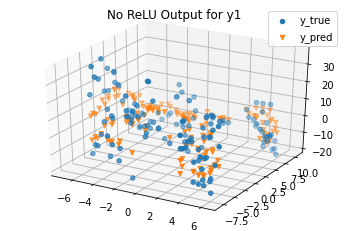

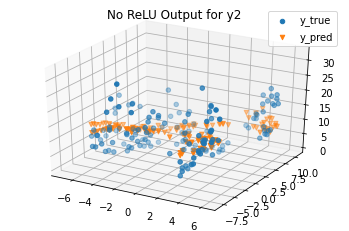

In [ ]:
plot_3d('No ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('No ReLU Output for y2', X, y_true[:,1], y_pred[:,1])